In [169]:
import numpy as np
import stat as stats
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline

Import the earthquake data

In [170]:
# Load earthquake data
loc = "earthquake files-20221127\EarthquakeExerciseData.txt"
data_earthquake = np.loadtxt(loc)

# assuming sensor standard deviation is 0.2 (this is the same as example 1.12 in the BRML book)
sensor_sd = 0.2

This is the modified Julia code that is provided. Changed it to get everything into more of a numpy format.
ie. world is Sx2 array with all world coordinates, 
sensors is a Nx2 array with all sensor coordinates


This function creates the world coordinates and the sensor locations

In [171]:
def earthquake_exercise_setup(station_num=30, spiral_points_num=2000, angular_spiral_rate=25):
    """Setup the spiral world coordinates of the earthquake model, returning world coordinates and the sensor coordinates
    This function is based on the earthquakeExerciseSetup.jl function provided from the BRML book toolbox. There are some modifications
    converting it to Python and changing some of the outputs

    Args:
        station_num (int, optional): Number of sensors on the surface of the world. Defaults to 30.
        spiral_points_num (int, optional): Number of discretized spiral world points. Defaults to 2000.
        angular_spiral_rate (int, optional): How many world points to step through to complete 1 full rotation in world coordinates. Defaults to 25.

    Returns:
        world (ndarray): spiral_points_num x 2 array. Element i is (x,y) coordinates of the i-th world point
        sensors (ndarray): station_num array x 2. Element i is (x,y) coordinates of the i-th sensor
    """
    
    # explosion detector (using spiral coordinate system)
    # define the coordinate system:
    S = spiral_points_num # number of points on the spiral
    rate = angular_spiral_rate # angular rate of spiral
    
    # array to hold world coordinates (x, y)
    world = np.zeros((S, 2))
    
    # iteratively work around the spiral filling in cartesian location values in x and y
    for s in range(S):
        r = s / S        
        theta = rate * 2 * np.pi * r
        world[s, 0] = r * np.cos(theta)
        world[s, 1] = r * np.sin(theta)

    # define the locations of the detection stations on the surface
    # Also define what value on each sensor would be generated by an explostion at internal location s
    N = station_num # number of stations
    
    # array to hold sensor locations
    sensors = np.zeros((N, 2))
    
    for sensor in range(N):
        # initialise x, y values for each sensor
        theta_sensor = 2 * np.pi * sensor / N
        sensors[sensor, 0] = np.cos(theta_sensor)
        sensors[sensor, 1] = np.sin(theta_sensor)
    
    return world, sensors

In [172]:
def calculate_likelihood_exponentials(world, sensors, sensor_data, sensor_sd, is_two_explosion=False):
    """This calculates the likelihood contribution from an explosion at the i-th world point with the observed signal from the j-th sensor
    It only calculates the power of the exponential for numerical accuracy
    If we are calculating for two explosions, then there is an additonal returned dimension to incorporate the likelihood of a 2nd explosion at the k-th world point

    Args:
        world (ndarray): Sx2 array, i-th element is (x,y) coordinates of i-th world point
        sensors (ndarray): Nx2 array, i-th element is (x,y) coordinates of i-th sensor
        sensor_data (ndarray): N array, i-th element is observed signal from i-th sensor
        sensor_sd (float): standard deviation of error in observed signal from each sensor
        is_two_explosion (bool, optional): bool flag indicating whether calculation is for 1 or 2 explosions. Defaults to False.

    Returns:
        F (ndarray): SxN array (SxSxN if two explosions). Element [i,j] is the log_likelihood contribution of explision at i-th world point, with the observed signal at j-th sensor
    """
    
    S = world.shape[0]
    N = sensors.shape[0]
    
    # Calculate distances between world point i and sensor j at index [i, j]
    dist = np.zeros((S, N))
    for sensor in range(N):
        dist[:, sensor] = np.linalg.norm(world - sensors[sensor], axis=1)
    
    # array of theoretical signal from a single explosion. At [i, j] is signal at point world[i], and signal at sensor[j]
    world_signal = 1 / (dist**2 + 0.1)
    
    # Calculate for 2 explosions:
    if is_two_explosion:
        F = np.zeros(shape=(S, S, N))
        for s1 in range(S):
            for s2 in range(S):
                F[s1, s2, :] = (sensor_data - world_signal[s1, :] - world_signal[s2, :])**2
                
    # calculate for 1 explosion:
    else:
        F = np.zeros(shape=(S, N))
        for s1 in range(S):
            F[s1, :] = (sensor_data - world_signal[s1, :])**2
    
    factor = -1 / (2 * pow(sensor_sd, 2))
    F = factor * F
    
    return F

In [173]:
def log_sum_of_exponential_components(F, sum_axis=0):
    """given an array F of exponential componenets, return log(np.exp(F).sum(axis=sum_axis))
    This uses a method of finding the maximum component and removing it from the log sum, this increases the numerical stability considerably.
    If calculated directly numerically it would often go to +/-inf

    Args:
        F (ndarray): array of exponential components
        sum_axis (int): axis to complete the sum along. Defaults to 0
    """
    # find the maximum term. Then when computing take the max outside the log sum to increase numerical stablility
    F_max = F.max(axis=sum_axis, keepdims=True)
    log_sum = F_max + np.log(np.exp(F - F_max).sum(axis=sum_axis, keepdims=True))
    
    # squeeze to remove the axis that has been summed over
    return log_sum.squeeze()

In [174]:
# Function to plot the world, sensors, visible signal, Highest likelihood location and likelihood heat map

def show_earth_likelihood(sensor_locations, world, like, sensor_data=None, axes=None, visual_scale=0.8, is_two_explosions=False, title='Title'):
    """Graphically show the likelihood of the earthquake model, with markers for max likelihood, and the signals observed at each sensor

    Args:
        sensor_locations (ndarray): Nx2 array, i-th element is (x,y) coordinates of i-th sensor
        world (ndarray): Sx2 array, i-th element is (x,y) coordinates of i-th world point
        like (ndarray): S array, likelihood (or log_likelihood) at each world point
        sensor_data (ndarray, optional):N array, i-th element is observed signal from i-th sensor. Defaults to None.
        axes (matplotlib: Axes, optional): Axes to plot onto. Defaults to None.
        visual_scale (float, optional): plot the top visual_scale percentage likelihood (like) points in greyscale. Defaults to 0.8.
        is_two_explosions (bool, optional): bool flag indicating whether calculation is for 1 or 2 explosions. Defaults to False.
        title (str, optional): Title to include on plot. Defaults to 'Title'.
    """
    # size of visible signal bars
    radial_scale = 0.05
    
    # create axes if not given any
    if axes is None:
        __, axes = plt.subplots()
    axes.set_title(title)
    
    draw_circle = plt.Circle((0, 0), 1,fill=False)

    axes.set_aspect(1)
    axes.add_artist(draw_circle)
    
    colormap = plt.cm.Greys #or any other colormap
    
    # take top visual_scale % of likelihoods that aren't -inf
    is_not_inf_index = np.logical_not(np.isinf(like))
    sorted_like = np.sort(like[is_not_inf_index])
    N = int(sorted_like.size) - 1
    visual_min = sorted_like[N - int(N * visual_scale)]
    
    normalize = colors.Normalize(vmin=visual_min, vmax=like.max())
    axes.scatter(world[:,0], world[:,1], c=like, s=5, cmap=colormap, norm=normalize, marker='*')
    
    if sensor_data is not None:
        # generate vectors pointing out from centre representing visible signal
        radial_signal = sensor_locations * radial_scale * sensor_data.reshape((-1, 1)) + sensor_locations
        for sensor in np.arange(sensor_locations.shape[0]):
            x = [sensor_locations[sensor, 0], radial_signal[sensor, 0]]
            y = [sensor_locations[sensor, 1], radial_signal[sensor, 1]]
            axes.plot(x, y, c='red')
    
    # plot the sensors onto the earth
    axes.scatter(sensor_locations[:,0], sensor_locations[:,1], c='black', s=15)
    
    # plot the max likelihood point
    max_like_index = like.argmax()
    axes.scatter(world[max_like_index,0], world[max_like_index,1], c='red', marker='x', s=70, label='Global Max likelihood')
    
    # if 2 explosions plot the second local maximum
    if is_two_explosions:
        # visually looking at plot we can see the second local maximum is in the right half of the world points (x > 0)
        world_right_index = world[:,0] > 0
        like_world_right = like[world_right_index]
        world_right = world[world_right_index]
        max_2_like_index = like_world_right.argmax()
        axes.scatter(world_right[max_2_like_index,0], world_right[max_2_like_index,1], c='red', marker='^', s=70, label='Local Max Likelihood')
    
    axes.legend()
    axes.axis('off')

Setup world and sensors coordinates and calculate likelihood

In [175]:
# setup world and sensors
world, sensors = earthquake_exercise_setup()

# calculate the likelihood exponential components for both 1 explosion (H1) and 2 explosions (H2)
like_exponentials_H1 = calculate_likelihood_exponentials(world, sensors, data_earthquake, sensor_sd=sensor_sd, is_two_explosion=False)
like_exponentials_H2 = calculate_likelihood_exponentials(world, sensors, data_earthquake, sensor_sd=sensor_sd, is_two_explosion=True)

# For H1 the loglikelihood is just a simple sum
log_like_H1 = like_exponentials_H1.sum(axis=1)

# But for H2 the likelihood is a sum of poructs, therefore we sum over the sensors (axis=2)
# and then use the log_sum function to calculate the second sum in a numerically stable way
log_like_H2 = log_sum_of_exponential_components(like_exponentials_H2.sum(axis=2), sum_axis=1)

show results

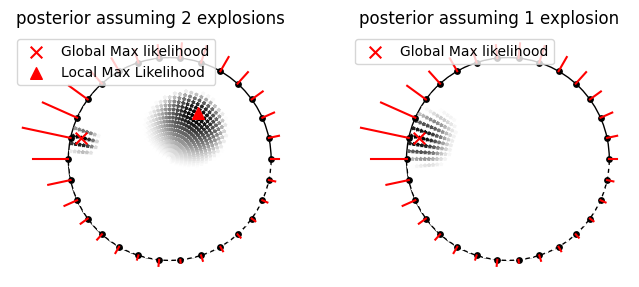

In [176]:
# plot the likelihoods
fig, axs = plt.subplots(1, 2, figsize=(8,8))
show_earth_likelihood(sensors, world, log_like_H2, data_earthquake, axes=axs[0], visual_scale=0.3, is_two_explosions=True, title='posterior assuming 2 explosions')
show_earth_likelihood(sensors, world, log_like_H1, data_earthquake, axes=axs[1], visual_scale=0.05, is_two_explosions=False, title='posterior assuming 1 explosion')

### Q1.1.b)
Find log(p(v|H2)) - log(p(v|H1))
where H1 and H2 are hypotheses that there is only 1 and 2 explosions respectively

In [177]:
# Continuing the assumption that priors p(s1) and p(s2) are constant over all world points
p_s1 = 1 / world.size
p_s2 = p_s1

log_prob_H1 =  np.log(p_s1) + log_sum_of_exponential_components(like_exponentials_H1.sum(axis=1))
log_prob_H2 =  np.log(p_s1) + np.log(p_s2) + log_sum_of_exponential_components(like_exponentials_H2.sum(axis=2).flatten())

answer = log_prob_H2 - log_prob_H1
print(f"log(p(v|H2)) - log(p(v|H1)) = {answer}")

log(p(v|H2)) - log(p(v|H1)) = 734.9872275796924
